In [1]:
"""
用MLP[全连接层]实现简单的序列模型
TO-DO:
    1.自己实现一下各种细节
"""
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"    # 这句不加会报莫名其妙的错


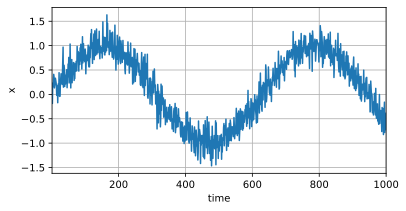

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))     # 构成后面的特征
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4     # 特征由tau个点组成，即使用tau个点可以预测后面一个点
features = torch.zeros(size=(T - tau, tau))     # 由上面的x进行填充--x就是一行数
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape(shape=(-1, 1))

batch_size, n_train = 16, 600   # n_train个样本参与训练
train_iter = d2l.load_array(data_arrays=(features[:n_train], labels[:n_train]),
                            batch_size=batch_size, is_train=True)

In [4]:
def init_weight(x):
    if type(x) == nn.Linear:
        nn.init.xavier_normal_(x.weight)

def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10), nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weight)
    return net

loss = nn.MSELoss(reduction='none')     # 平方损失而已~

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.sum().backward()
            train_loss_sum += l.sum()
            trainer.step()
        print(f'epoch {epoch + 1}, loss {d2l.evaluate_loss(net, train_iter, loss):f}\t'
                f'scc_loss {train_loss_sum}')

net = get_net()
train(net, train_iter, loss, 50, .01)

epoch 1, loss 0.069834	scc_loss 51.677547454833984
epoch 2, loss 0.061569	scc_loss 37.7109489440918
epoch 3, loss 0.058538	scc_loss 34.712982177734375
epoch 4, loss 0.054315	scc_loss 35.19994354248047
epoch 5, loss 0.055186	scc_loss 32.4030876159668
epoch 6, loss 0.051311	scc_loss 32.613197326660156
epoch 7, loss 0.051581	scc_loss 32.40752410888672
epoch 8, loss 0.052748	scc_loss 31.101665496826172
epoch 9, loss 0.056131	scc_loss 30.860729217529297
epoch 10, loss 0.049522	scc_loss 31.540538787841797
epoch 11, loss 0.049962	scc_loss 30.989795684814453
epoch 12, loss 0.052530	scc_loss 30.642980575561523
epoch 13, loss 0.050625	scc_loss 32.45469284057617
epoch 14, loss 0.051818	scc_loss 30.055139541625977
epoch 15, loss 0.049840	scc_loss 30.685941696166992
epoch 16, loss 0.049367	scc_loss 31.148107528686523
epoch 17, loss 0.054433	scc_loss 30.784317016601562
epoch 18, loss 0.051229	scc_loss 31.057662963867188
epoch 19, loss 0.051495	scc_loss 30.776935577392578
epoch 20, loss 0.050270	scc_

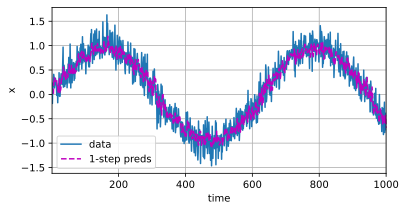

In [7]:
""" 单步预测 """
onestep_preds = net(features)
d2l.plot(X=[time, time[tau:]], Y=[x.detach().numpy(), onestep_preds.detach().numpy()], 
        xlabel='time', ylabel='x', legend=['data', '1-step preds'], xlim=[1, T], figsize=(6, 3))

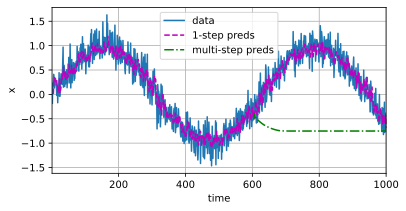

In [10]:
""" 多步预测：使用预测的数据继续预测 """
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]     # 因为下面的代码仅使用没参加过训练的点来进行预测，没参加过训练的前tau个点就是x[n_train:n_tain + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape(shape=(1, -1)))

d2l.plot(X=[time, time[tau:], time[n_train + tau:]],
        Y = [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()],
        xlabel='time', ylabel='x', legend=['data', '1-step preds', 'multi-step preds'],
        xlim=[1, T], figsize=(6, 3))

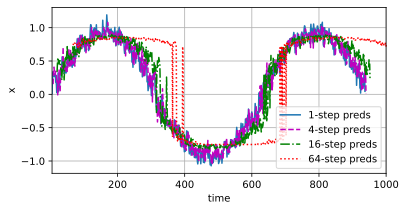

In [12]:
max_steps = 64
features = torch.zeros(size=(T - tau - max_steps + 1, tau + max_steps))     # 先知道features在此处是几行几列的，先不管他为什么如此
for i in range(tau):    # 观测值
    features[:, i] = x[i:i + T - tau - max_steps + 1]   # features前tau列是观测值，用于后面多步预测
for i in range(tau, tau + max_steps):   # 通过单步预测的结果继续向后预测(多步预测)
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = [1, 4, 16, 64]
d2l.plot(X=[time[tau + i - 1:T - max_steps + i] for i in steps], 
        Y=[features[:, tau + i - 1].detach().numpy() for i in steps],
        xlabel='time', ylabel='x', 
        legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
        figsize=(6, 3))